In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 128, 128, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

(656, 128, 128, 1) (128, 128, 128, 1)


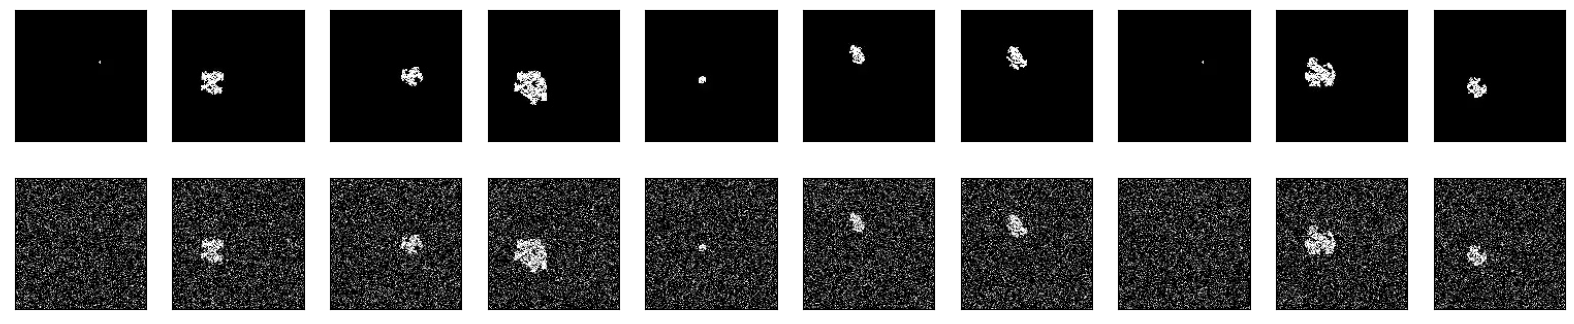

In [9]:
#loading in the data

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
data = [] 

for i in range(41):
    for j in range(16):
        image_name = 'video%s_frame_%s.jpg' % (i,j)
        im = mpimg.imread('%s' % (image_name))
        #plt.imshow(im)
        #plt.show()   #these commented out lines of code will print out all the images
        im = cv2.imread(image_name, 0).flatten()  #read image as grayscale. Set second parameter to 1 if rgb is required 
        data.append(im)#value of 0 = black, 255 = white
data = np.asarray(data)  


test_data = []
for i in range(8):
    for j in range(16):
        image_name = 'video%s_frame_%s.jpg' % (i+41,j)
        im = mpimg.imread('%s' % (image_name))
        #plt.imshow(im)
        #plt.show()   
        im = cv2.imread(image_name, 0).flatten()
        test_data.append(im)
        
test_data = np.asarray(test_data)

data = preprocess(data)
test_data = preprocess(test_data)

print(np.shape(data), np.shape(test_data))
#add noise
noisy_data = noise(data)
noisy_test_data = noise(test_data) 

#display images
display(data, noisy_data)

This next cell import necessary modules for CAE and creates useful Functions (from https://keras.io/examples/vision/autoencoder/)

The next cell is the cell to carry out the Convolutional Autoencoder (based off of https://keras.io/examples/vision/autoencoder/)

In [24]:
#commented out encoder and decoder parts are from a previous method I was trying
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

input = layers.Input(shape=(128, 128, 1))

# Encoder

x = layers.Conv2D(32, (3, 3), strides= 2, activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3),strides= 2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(32, (3, 3),strides= 2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3),strides = 2, activation="relu", padding="same")(x)
#x = layers.Conv2DTranspose(32, (5, 5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3,), activation="sigmoid", padding="same")(x)

# Autoencoder
callback = EarlyStopping(monitor='loss', patience=3)
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 32, 32, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 64, 64, 32)       9248

The cell underneath is used to fit the autoencoder

In [25]:
import numpy as np
print(np.shape(noisy_data))
print(np.shape(data))
history = autoencoder.fit(
    x=noisy_data,
    y=data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
    callbacks = [callback]
)

(656, 128, 128, 1)
(656, 128, 128, 1)
Epoch 1/50
6/6 [==============================] - 6s 947ms/step - loss: 0.6886 - val_loss: 0.6784
Epoch 2/50
6/6 [==============================] - 6s 921ms/step - loss: 0.6628 - val_loss: 0.6492
Epoch 3/50
6/6 [==============================] - 6s 904ms/step - loss: 0.5753 - val_loss: 0.5741
Epoch 4/50
6/6 [==============================] - 5s 872ms/step - loss: 0.3226 - val_loss: 0.3865
Epoch 5/50
6/6 [==============================] - 6s 891ms/step - loss: 0.2009 - val_loss: 0.2693
Epoch 6/50
6/6 [==============================] - 6s 885ms/step - loss: 0.2083 - val_loss: 0.2691
Epoch 7/50
6/6 [==============================] - 6s 886ms/step - loss: 0.1518 - val_loss: 0.2954
Epoch 8/50
6/6 [==============================] - 6s 905ms/step - loss: 0.1468 - val_loss: 0.2491
Epoch 9/50
6/6 [==============================] - 6s 924ms/step - loss: 0.1274 - val_loss: 0.1679
Epoch 10/50
6/6 [==============================] - 5s 864ms/step - loss: 0.1183 

## Plotting val_loss and loss

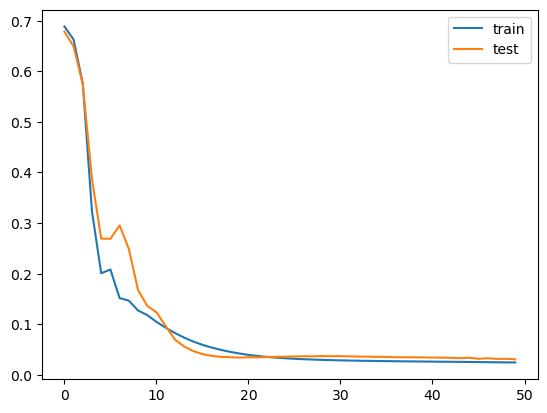

In [26]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Analysis


Using a Convolutional autoencoder model that uses noise and compresses the image from to 128x128 to 32x32 with kernels of size (3,3) has a loss = 0.0180 and val_loss = 0.0118 after 50 epochs

Changing this to include stride (2,2) (to hopefully speed up process) and change kernels to size (5,5) has a loss of = 0.0215 and val_loss = 0.0150. This did not speed up the process use original architecture. 

Changing this to compress image to 32x32. Loss = 0.0234, val_loss = 0.0153. (more value lost but image compressed further)

Getting rid of MaxPooling2D function but using strides of (2,2) changes loss and val_loss. Loss = 0.0195, val_loss = 0.0128

First code underneath will show the predictions of the CAE on test data displayed for compression to 32x32. 
Second code underneath will show the predictions of the CAE on test data displayed for compression to 16x16.
(from https://keras.io/examples/vision/autoencoder/)


(Have continued to explore model since this analysis which is why model has certain layers commented out)

4/4 [==============================] - 0s 64ms/step


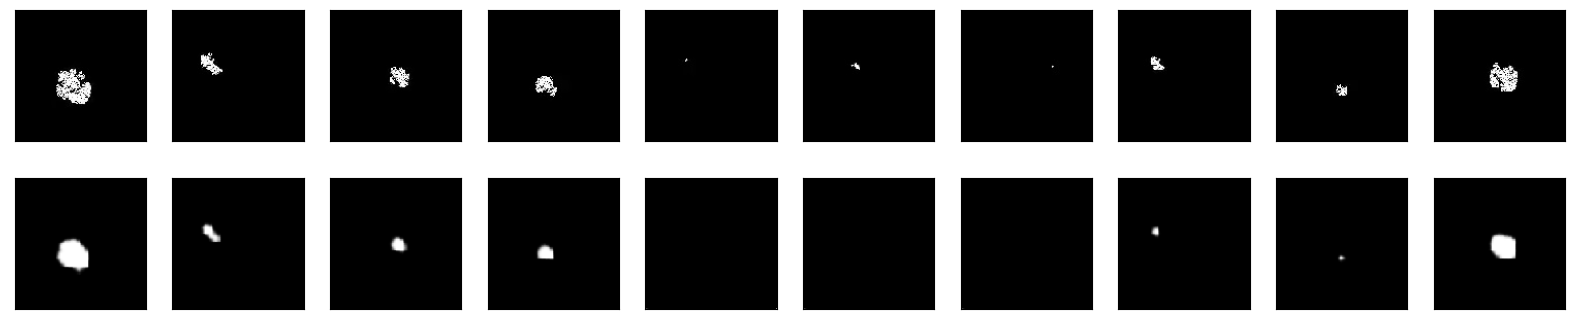

In [27]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

4/4 [==============================] - 1s 210ms/step


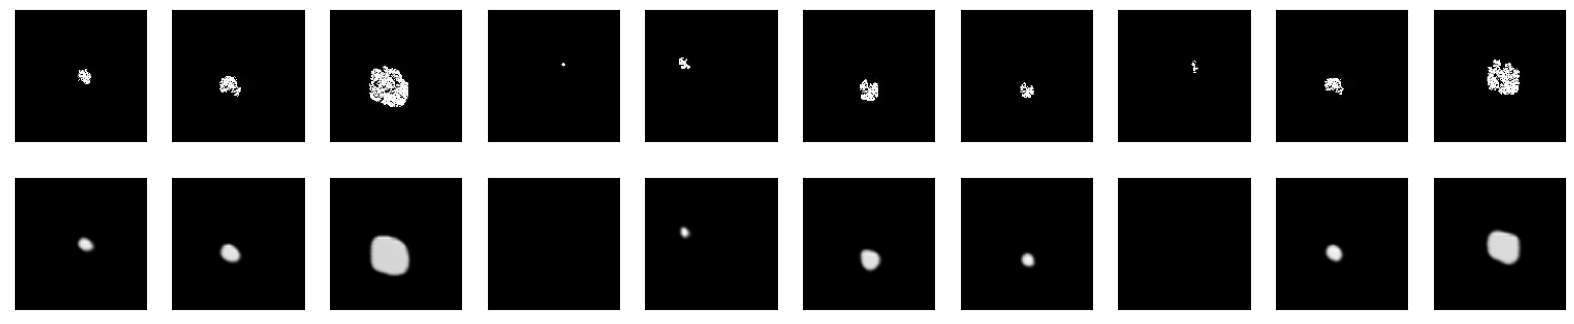

In [38]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)